In [309]:
import numpy as np
import pandas as pd
import keras
import kagglehub
import os
import tensorflow as tf
from preprocessing import preprocess_and_split_data
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Input, Embedding, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import ops
from keras_hub.layers import TransformerEncoder, PositionEmbedding
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, f1_score, accuracy_score

In [15]:
# Load data
# https://www.kaggle.com/datasets/thearijitdas/fake-reviews-dataset
path = kagglehub.dataset_download("thearijitdas/fake-reviews-dataset")

print("Path to dataset files:", path)

df = pd.read_csv(os.path.join(path, 'fake_reviews_dataset.csv'))
df.head(5)

Path to dataset files: /Users/benbrown/.cache/kagglehub/datasets/thearijitdas/fake-reviews-dataset/versions/4


,category,rating,text,label
0,Home_and_Kitchen,5.0,"Love this! Well made, sturdy, and very comfor...",1
1,Home_and_Kitchen,5.0,"love it, a great upgrade from the original. I...",1
2,Home_and_Kitchen,5.0,This pillow saved my back. I love the look and...,1
3,Home_and_Kitchen,1.0,"Missing information on how to use it, but it i...",1
4,Home_and_Kitchen,5.0,Very nice set. Good quality. We have had the s...,1


In [31]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/benbrown/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [476]:
def preprocess_and_split_data(df):
    # Load stop words and initialize stemmer
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    # Preprocessing function: remove stop words and apply stemming
    def preprocess_text(text):
        words = text.split()
        filtered_words = [stemmer.stem(word) for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words)

    # Split the data into training and testing sets (80% train, 20% test)
    X = df['text']  # Features (text data)
    y = df['label']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply preprocessing to the training and testing sets separately
    X_train = X_train.apply(preprocess_text)
    X_test = X_test.apply(preprocess_text)

    # Tokenize and pad sequences
    max_words = 10000  # Hardcoded maximum number of words
    max_len = 100      # Hardcoded maximum sequence length
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

    # Return the processed datasets and tokenizer
    return X_train_pad, X_test_pad, y_train, y_test, tokenizer

In [478]:
# Example usage for preprocessing
X_train, X_test, y_train, y_test, tokenizer = preprocess_and_split_data(df)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (32420, 100) (32420,)
Test shape: (8106, 100) (8106,)


In [480]:
num_words = len(tokenizer.word_index) + 1
num_words

36411

I use the positional embedding layer from the English to Portuguese translator model notebook.

In [482]:
# Define the positional encoding layer
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [484]:
# Define positional embedding layer
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [486]:
word_count = len(tokenizer.word_index) + 1
test_embed = PositionalEmbedding(vocab_size=word_count, d_model=512)
embed_x0 = test_embed(X_train[0].reshape(-1,1))
print(embed_x0.shape)
print(embed_x0._keras_mask.shape)

(100, 1, 512)
(100, 1)


In [488]:
model = Sequential([
    PositionalEmbedding(vocab_size=word_count, d_model=100),  # Match tokenizer and padding
    TransformerEncoder(intermediate_dim=128, num_heads=8, dropout=0.1),
    Flatten(),
    Dropout(0.1),
    Dense(1, activation='sigmoid')  # For binary classification
])

In [490]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'flatten_25' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1014/1014 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.7435 - loss: 0.5284 - val_accuracy: 0.8975 - val_loss: 0.2697
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.9466 - loss: 0.1313 - val_accuracy: 0.9039 - val_loss: 0.2403
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step - accuracy: 0.9781 - loss: 0.0618 - val_accuracy: 0.8971 - val_loss: 0.3270
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9884 - loss: 0.0355 - val_accuracy: 0.8959 - val_loss: 0.4006
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.9906 - loss: 0.0253 - val_accuracy: 0.8955 - val_loss: 0.4299


In [492]:
model.evaluate(X_test, y_test)

254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9012 - loss: 0.2445


[0.2402818351984024, 0.9038983583450317]

  9/254 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'flatten_25' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


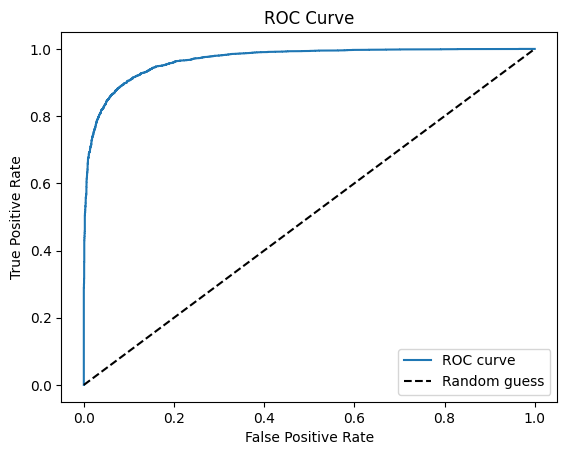

In [494]:
# Assuming 'model' is your trained Keras model and 'X_test', 'y_test' are your test data
y_pred_proba = model.predict(X_test)

# For binary classification, if the output layer uses sigmoid activation:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# For multi-class classification, consider one-vs-rest approach or use roc_auc_score for AUC only
# fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred_proba.ravel()) # Example for binary case

# Plotting the ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [348]:
# Compute threshold based on F1 score
y_pred = 0
best_thresh = 0
best_f1 = 0
for i in np.arange(100)/100:
    y_pred_int = (y_pred_proba > i)*1.0
    f1 = f1_score(y_test, y_pred_int)
    #print(f'Threshold {i}: {f1}')
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = i
        y_pred = y_pred_int
print(f'Best threshold: {best_thresh}')
print(f'Best F1 score: {best_f1}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Best threshold: 0.86
Best F1 score: 0.9087296659629952
Accuracy: 0.9093264248704663


### Add more encoder layers

Adding dropout makes the test accuracy slightly worse so it is likely the model is underfitting.

In [351]:
model2 = Sequential([
    PositionalEmbedding(vocab_size=word_count, d_model=100),  # Match tokenizer and padding
    TransformerEncoder(intermediate_dim=128, num_heads=8, dropout=0.1),
    TransformerEncoder(intermediate_dim=128, num_heads=8, dropout=0.1),
    TransformerEncoder(intermediate_dim=128, num_heads=8, dropout=0.1),
    TransformerEncoder(intermediate_dim=128, num_heads=8, dropout=0.1),
    Flatten(),
    Dropout(0.1),
    Dense(1, activation='sigmoid')  # For binary classification
])

In [353]:
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history2 = model2.fit(
    X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'flatten_20' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1014/1014 ━━━━━━━━━━━━━━━━━━━━ 123s 118ms/step - accuracy: 0.7256 - loss: 0.5914 - val_accuracy: 0.8955 - val_loss: 0.2485
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 120s 119ms/step - accuracy: 0.9396 - loss: 0.1558 - val_accuracy: 0.9132 - val_loss: 0.2214
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 121s 119ms/step - accuracy: 0.9648 - loss: 0.0901 - val_accuracy: 0.8987 - val_loss: 0.2857
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 119s 118ms/step - accuracy: 0.9723 - loss: 0.0695 - val_accuracy: 0.9056 - val_loss: 0.3507
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 119s 117ms/step - accuracy: 0.9766 - loss: 0.0602 - val_accuracy: 0.9109 - val_loss: 0.3385


In [355]:
model2.evaluate(X_test, y_test)

254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9116 - loss: 0.2207


[0.22143472731113434, 0.9131507277488708]

  3/254 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step  

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'flatten_20' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step


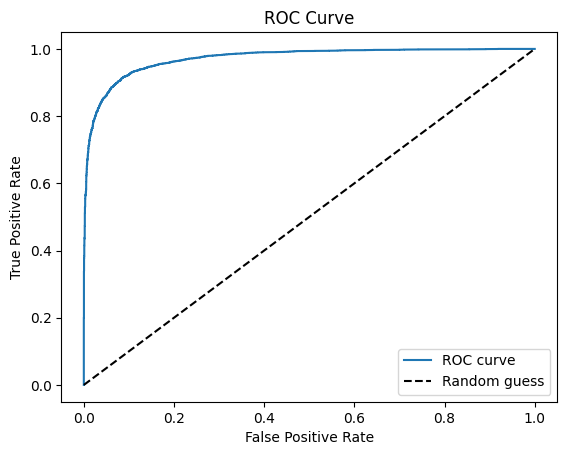

In [357]:
# Assuming 'model' is your trained Keras model and 'X_test', 'y_test' are your test data
y_pred_proba2 = model2.predict(X_test)

# For binary classification, if the output layer uses sigmoid activation:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba2)

# For multi-class classification, consider one-vs-rest approach or use roc_auc_score for AUC only
# fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred_proba.ravel()) # Example for binary case

# Plotting the ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Increasing the number of layers only slightly improves the model performance. Now I will try using fewer layers but increasing the intermediate dimension of each layer.

In [360]:
model3 = Sequential([
    PositionalEmbedding(vocab_size=word_count, d_model=100),  # Match tokenizer and padding
    TransformerEncoder(intermediate_dim=512, num_heads=8, dropout=0.1),
    TransformerEncoder(intermediate_dim=512, num_heads=8, dropout=0.1),
    Flatten(),
    Dropout(0.1),
    Dense(1, activation='sigmoid')  # For binary classification
])

In [362]:
model3.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history3 = model3.fit(
    X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'flatten_21' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1014/1014 ━━━━━━━━━━━━━━━━━━━━ 77s 74ms/step - accuracy: 0.7141 - loss: 0.6488 - val_accuracy: 0.9124 - val_loss: 0.2263
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 75s 74ms/step - accuracy: 0.9422 - loss: 0.1443 - val_accuracy: 0.8995 - val_loss: 0.2566
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 76s 74ms/step - accuracy: 0.9708 - loss: 0.0781 - val_accuracy: 0.9071 - val_loss: 0.2699
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 76s 75ms/step - accuracy: 0.9828 - loss: 0.0438 - val_accuracy: 0.8925 - val_loss: 0.4172


In [364]:
model3.evaluate(X_test, y_test)

254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9123 - loss: 0.2293


[0.2262546867132187, 0.91241055727005]

It performs nearly identically to the model with 4 layers but takes half as long to train. Now let's try adding more or less dropout to the model.

In [371]:
model4 = Sequential([
    PositionalEmbedding(vocab_size=word_count, d_model=100),  # Match tokenizer and padding
    TransformerEncoder(intermediate_dim=512, num_heads=8, dropout=0.25),
    TransformerEncoder(intermediate_dim=512, num_heads=8, dropout=0.25),
    Flatten(),
    Dropout(0.25),
    Dense(1, activation='sigmoid')  # For binary classification
])

In [373]:
model4.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history4 = model4.fit(
    X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'flatten_23' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1014/1014 ━━━━━━━━━━━━━━━━━━━━ 77s 75ms/step - accuracy: 0.6890 - loss: 0.7369 - val_accuracy: 0.9070 - val_loss: 0.2213
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 75s 74ms/step - accuracy: 0.9360 - loss: 0.1578 - val_accuracy: 0.9075 - val_loss: 0.2327
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 76s 75ms/step - accuracy: 0.9631 - loss: 0.0969 - val_accuracy: 0.9114 - val_loss: 0.2774
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 75s 74ms/step - accuracy: 0.9736 - loss: 0.0686 - val_accuracy: 0.9069 - val_loss: 0.3499


In [378]:
model4.evaluate(X_test, y_test)

254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9052 - loss: 0.2234


[0.22131945192813873, 0.9069824814796448]

In [496]:
# Largest model with 4 layers and intermediate dim 512
model5 = Sequential([
    PositionalEmbedding(vocab_size=word_count, d_model=100),  # Match tokenizer and padding
    TransformerEncoder(intermediate_dim=512, num_heads=8, dropout=0.1),
    TransformerEncoder(intermediate_dim=512, num_heads=8, dropout=0.1),
    TransformerEncoder(intermediate_dim=512, num_heads=8, dropout=0.1),
    TransformerEncoder(intermediate_dim=512, num_heads=8, dropout=0.1),
    Flatten(),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

In [500]:
model5.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history5 = model5.fit(
    X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'flatten_26' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1014/1014 ━━━━━━━━━━━━━━━━━━━━ 149s 143ms/step - accuracy: 0.6938 - loss: 0.5951 - val_accuracy: 0.9076 - val_loss: 0.2301
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 144s 142ms/step - accuracy: 0.9285 - loss: 0.1762 - val_accuracy: 0.9099 - val_loss: 0.2355
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 142s 140ms/step - accuracy: 0.9521 - loss: 0.1227 - val_accuracy: 0.8870 - val_loss: 0.3116
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 146s 144ms/step - accuracy: 0.9631 - loss: 0.0974 - val_accuracy: 0.9022 - val_loss: 0.3128


In [502]:
model5.evaluate(X_test, y_test)

254/254 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9065 - loss: 0.2289


[0.23007379472255707, 0.9075993299484253]

In [470]:
# Get reviews that are most and least likely to be AI.
indices = np.argsort(y_pred_proba2.flatten())
for i in indices[0:5]:
    print(y_pred_proba2[i], tokenizer.sequences_to_texts([X_test[i]]))

[1.8482011e-05] ['televis report jessica rowan cover san antonio gener bachelor auction friend win date ryder last thing altern captain ryder want particip bachelor auction however two meet might common would expected contemporari sport romanc suitabl new adult adult audiences like ryder seriou hockey fault appreci ryder call one realiz need achiev balanc life valuabl life lesson benefit everyone felt bad jessica auction love friend ryder her obstacl overcom make stori interesting two great chemistri make excel couple seven pages stori fast captiv read finish one sitting enjoy scene begin thought clever way charact get together chase prize fun stori entertain read im look forward casey stori next book six make impact']
[2.923547e-05] ['one best cup there daughter love push button own encourag drinking leaking easi transport like much bought another also mani thank custom servic folk thermo buy replac mouth piec defect extend use']
[3.8567938e-05] ['work great bright ballast compat even

In [474]:
for i in indices[-6:-1]:
    print(y_pred_proba2[i], tokenizer.sequences_to_texts([X_test[i]]))

[0.9999956] ['make purchas base know things one tim problem best thing light need take care littl bit light it big problem light bit bright small problem light bit dim big problem light bright small problem light bright big problem light bright small problem light bright big problem light dim']
[0.999997] ['actual bought son qualiti good reason gave 4 star plastic part hard put on materi thick materi durable would suggest']
[0.99999726] ['thing real profession qualiti product also strong one want get feet wet trs 80 go it']
[0.9999974] ['gener backpack purposes excel qualiti chain keep next coupl years beginner probabl chain you experienc rider go chain bought husband christma love it impress qualiti construction happi it works love fact easi use carry thing would chang color']
[0.9999979] ['chip coffe kind sweet treat admit tempt give book try charact complex plot interesting recommend book mani people good book receiv free copi book netgalley exchang honest review i love read live yo

In [506]:
real_rev = 'This plant pot looks good and fits the plant well. Was a reasonable price, but I am concerned about how to tell how much water my plant will need because I can’t see when water comes out the bottom.'

In [544]:
real_tokens = np.array(tokenizer.texts_to_sequences([real_rev]))
real_tokens = pad_sequences(real_tokens, maxlen=100, padding='post')
real_tokens

array([[ 171, 2660, 1097, 2607,    5,  339, 3170,  300, 2660,   10, 1186,
         166, 4673,   47,  526,   18, 2580, 6932,  975, 2739,  397,  307,
        2739,   43,  162, 5506, 2660, 1070,   55, 6629,   18,   53, 3102,
         162, 7990,  214,  300,  303,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)

In [546]:
model2.predict(real_tokens)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.49317297]], dtype=float32)

In [548]:
fake_rev = 'Sturdy and stylish! This ceramic planter is well-made with a clean, modern look. The drainage hole is a great feature, and it fits medium-sized plants perfectly. Great value for the price—highly recommend for indoor use.'

In [550]:
fake_tokens = np.array(tokenizer.texts_to_sequences([fake_rev]))
fake_tokens = pad_sequences(fake_tokens, maxlen=100, padding='post')
fake_tokens

array([[ 274,  339, 2008,  171,  384,   10,   41,  485,  166,  159, 1540,
          17,  300,  525,  384,  166,    2, 1329,  339,    6, 3170,  431,
        4867, 8421,  238,    2,  497,  461,  300,   16,  461, 1963,    8,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)

In [552]:
model2.predict(fake_tokens)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


array([[0.0854285]], dtype=float32)